## Dependencias

In [228]:
import numpy as np
import pandas as pd
import datetime as datetime

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import cufflinks as cf
import matplotlib.pyplot as plt

cf.go_offline()

## Lectura de datos

In [229]:
ruta='/home/oscarjarillo/Documentos/Análisis Multivariado/Perceptron/diabetes.csv'
df = pd.read_csv(ruta)
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [230]:
df.shape

(768, 9)

In [231]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [232]:
df.insert(0,'id',df.index+1)

## Definición de variables

In [233]:
um = ['id']
vart = ['Outcome']
varc = [v for v in df.columns if v not in um and v not in vart]

## Análisis exploratorio

### Valores nulos

In [234]:
nulos = 1-df.describe().T[['count']]/len(df)
nulos

,count
id,0.0
Pregnancies,0.0
Glucose,0.0
BloodPressure,0.0
SkinThickness,0.0
Insulin,0.0
BMI,0.0
DiabetesPedigreeFunction,0.0
Age,0.0
Outcome,0.0


### Varianza nula

In [235]:
X = df[varc].copy()

In [236]:
vt = VarianceThreshold()
vt.fit(X)

VarianceThreshold()

In [237]:
fuera = [a for a,b in zip(varc,vt.get_support()) if not b]
fuera

[]

### Selección de variables con mejor poder predictivo

In [238]:
X[vart] = df[vart]

In [239]:
sk = SelectKBest(k=len(varc))
sk.fit(X[varc],X[vart[0]])

SelectKBest(k=8)

In [240]:
aux = pd.DataFrame(zip(varc,sk.scores_),columns=['var','score']).set_index('var').sort_values(by='score',
                                                                ascending=False).iplot(kind='bar',color='orange')

In [241]:
sk = SelectKBest(k=7)
sk.fit(X[varc],X[vart[0]])
best = [a for a,b in zip(varc,sk.get_support()) if b]
best

['Pregnancies',
 'Glucose',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

### Valores extremos

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'SkinThickness'}>],
       [<AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

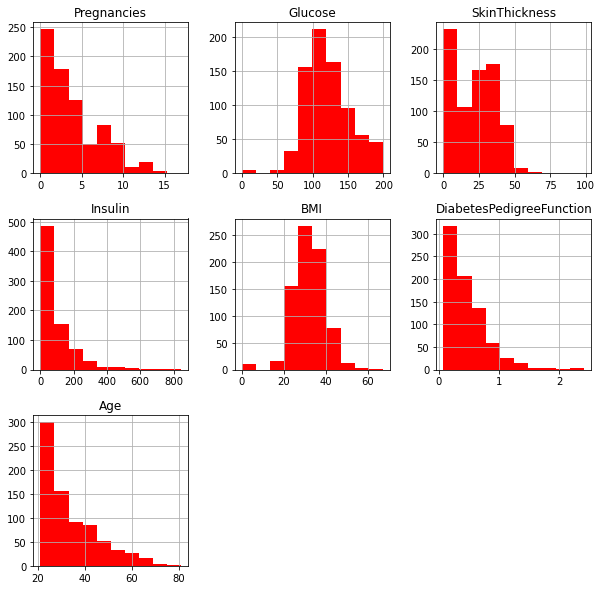

In [242]:
X[best].hist(figsize=(10,10),color='red')

In [243]:
for v,li,ls in X[best].describe(percentiles=[0.01,0.99]).T[['1%','99%']].reset_index().values:
    X[f'ex_{v}'] = ((X[v]<li)|(X[v]>ls)).astype(int)
X['ex_'] = X.filter(like='ex_').max(axis=1)
X['ex_'].value_counts(1)

0    0.928385
1    0.071615
Name: ex_, dtype: float64

In [244]:
X[um+vart] = df[um+vart]

In [245]:
X = X.loc[X['ex_']==0].drop(X.filter(like='ex_').columns,axis=1).reset_index(drop=True)

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'SkinThickness'}>],
       [<AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>,
        <AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>],
       [<AxesSubplot:title={'center':'Age'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

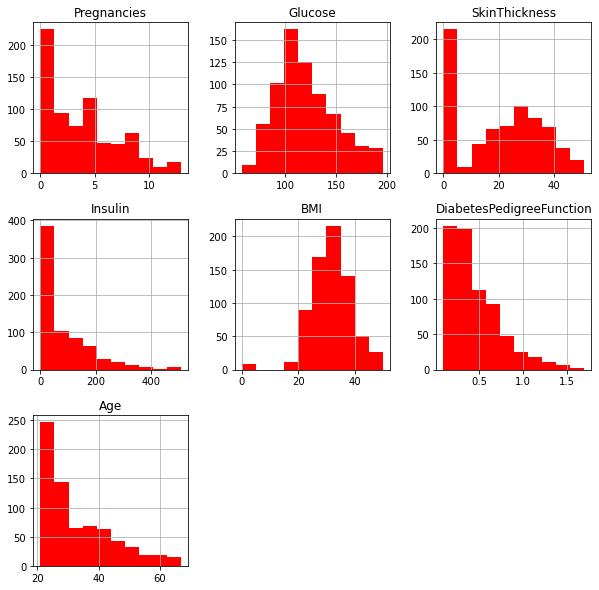

In [246]:
X[best].hist(figsize=(10,10),color='red')

### Cambio de espacio $\mathcal{X}_{[0,1]}$

In [247]:
sc = MinMaxScaler()
sc.fit(X[best])

MinMaxScaler()

In [248]:
X01 = pd.DataFrame(sc.transform(X[best]),columns=best)
X01[um+vart] = X[um+vart]

## Partición

In [249]:
Xt,Xv,yt,yv = train_test_split(X01[um+best],X01[um+vart],train_size=0.7)
Xt.reset_index(drop=True,inplace=True)
Xv.reset_index(drop=True,inplace=True)
yt.reset_index(drop=True,inplace=True)
yv.reset_index(drop=True,inplace=True)

## Aprendizaje

In [250]:
modelo = LinearDiscriminantAnalysis()
modelo.fit(Xt[best],yt[vart[0]])

LinearDiscriminantAnalysis()

## Validación del modelo

In [251]:
St = Xt.merge(yt,on=um,how='inner')
Sv = Xv.merge(yv,on=um,how='inner')

In [252]:
St['y^'] = modelo.predict(Xt[best])
Sv['y^'] = modelo.predict(Xv[best])

St['proba'] = modelo.predict_proba(Xt[best])[:,1]
Sv['proba'] = modelo.predict_proba(Xv[best])[:,1]

In [253]:
print(accuracy_score(y_pred=St['y^'],y_true=St[vart[0]]))
print(accuracy_score(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

0.7635270541082164
0.8130841121495327


In [254]:
print(roc_auc_score(y_true=St[vart[0]],y_score=St['proba']))
print(roc_auc_score(y_true=Sv[vart[0]],y_score=Sv['proba']))

0.8169139996424101
0.8783255086071987


In [255]:
print(confusion_matrix(y_pred=St['y^'],y_true=St[vart[0]]))
print(confusion_matrix(y_pred=Sv['y^'],y_true=Sv[vart[0]]))

[[292  37]
 [ 81  89]]
[[134   8]
 [ 32  40]]
